In [2]:
import numpy as np
from filterpy.common import Saver
import matplotlib.pyplot as plt
from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import JulierSigmaPoints

In [3]:
dt = 0.033  # 卡尔曼滤波计算时间间隔,单位为s
F = 36 # 焦距 mm
CCD_SIZE = 11.264 # 传感器尺寸 mm
WIDTH = 2048
HEIGHT = 2048
M = 4 # 卡尔曼滤波器跟踪的点的个数

def fromImageToPixel(x, y):
    dx = CCD_SIZE / WIDTH
    dy = CCD_SIZE / HEIGHT
    u = x/dx + WIDTH/2
    v = y/dy + HEIGHT/2
    return u, v

def fromCameraToImage(x, y, z):
    x_new = (F * x) / z
    y_new = (F * y) / z
    return x_new, y_new

def fx(x, dt):
    st = np.zeros(3 * M + 12)
    s1 = x[0]
    s2 = x[1]
    s3 = x[2]
    s4 = x[3]
    s5 = x[4]
    s6 = x[5]
    s7 = x[6]
    s8 = x[7]
    s9 = x[8]
    s10 = x[9]
    s11 = x[10]
    s12 = x[11]
    st[0] = s3 - s1 * s5
    st[1] = s4 - s2 * s5
    st[2] = -s3 * s5
    st[3] = -s4 * s5
    st[4] = -s5 ** 2
    st[5] = 0.5 * (s12 * s7 - s11 * s8 + s10 * s9)
    st[6] = 0.5 * (-s12 * s6 + s10 * s8 + s11 * s9)
    st[7] = 0.5 * (s11 * s6 - s10 * s7 + s12 * s9)
    st[8] = 0.5 * (-s10 * s6 - s11 * s7 - s12 * s8)
    st[9] = 0
    st[10] = 0
    st[11] = 0
    for i in range(0, 3 * M):
        st[i + 12] = -x[i + 12] * s5

    return dt * st + x

def hx(x):
    # 观测函数
    s1 = x[0]
    s2 = x[1]
    s6 = x[5]
    s7 = x[6]
    s8 = x[7]
    s9 = x[8]
    ob = np.zeros(2*M)
    for i in range(0, M):
        n1 = s1 + np.dot(np.array([[s6**2-s7**2-s8**2+s9**2, 2*(s6*s7+s8*s9), 2*(s6*s8-s7*s9)]]),
                              np.array([[x[i*3+12]], [x[i*3+13]], [x[i*3+14]]]))[0][0]

        n2 = s2 + np.dot(np.array([[2*(s6*s7-s8*s9), -s6**2+s7**2-s8**2+s9**2, 2*(s7*s8+s6*s9)]]),
                              np.array([[x[i*3+12]], [x[i*3+13]], [x[i*3+14]]]))[0][0]

        d = 1 + np.dot(np.array([[2*(s6*s8+s7*s9), 2*(s7*s8-s6*s9), -s6**2-s7**2+s8**2+s9**2]]),
                       np.array([[x[i*3+12]], [x[i*3+13]], [x[i*3+14]]]))[0][0]
        ob[i*2] = n1/d
        ob[i*2+1] = n2/d

    return F*ob

In [5]:
# sigmas = JulierSigmaPoints(n=3*M+12, kappa=1)
sigmas = MerweScaledSigmaPoints(3*M+12, alpha=.1, beta=2., kappa=1.)
indexs = [1, 7, 5, 3]
measured_points = []
for i in range(200):
    fileName = "/Users/apple/Desktop/test/Cube/pos"+str(i)+".txt"
    with open(fileName, "r") as file:
        temp = []
        lines = file.readlines()
        for index in indexs:
            line = lines[index].strip("\n").split()
            # 相机坐标系转换到图像坐标系(y值要取反！！！！！！！！！！)
            x, y = fromCameraToImage(float(line[0]), -float(line[1]), float(line[2]))
            temp.append(x)
            temp.append(y)

        measured_points.append(temp)

ukf = UnscentedKalmanFilter(dim_x=3*M+12, dim_z=2*M, dt=dt, hx=hx, fx=fx, points=sigmas)
ukf.P *= 2
ukf.R *= 0.000005
ukf.Q *= 0.000001

s0 = [100., 0., 6930.693]
# 初值:小行星坐标系到相机坐标系坐标系旋转矩阵(四元数)(y值要取反！！！！！！！！！！)
q0 = [-0.000000, 0.382683,  -0.000000, 0.923880]
# M个特征点在小行星坐标系下的坐标（不随时间变化,y值要取反！！！！！！！！！！)
points0 = [[0., -200., 0.], [0., -200., 200.], [200., -200., 200.], [200., -200., 0.]]
points0 = [[-100., -100., -100.], [-100., -100., 100.], [100., -100., 100.], [100., -100., -100.]]
# 初值：小行星坐标系x,y,z方向的角速度初值
w0 = [0.1, 100., 0.1]
# 初值：小行星坐标原点在相机坐标系下x,y,z方向速度初值
v0 = [0.1, 0.1, 0.1]

ukf.x[0] = s0[0]/s0[2]
ukf.x[1] = s0[1]/s0[2]
ukf.x[2] = v0[0]/s0[2]
ukf.x[3] = v0[1]/s0[2]
ukf.x[4] = v0[2]/s0[2]
ukf.x[5] = q0[0]
ukf.x[6] = q0[1]
ukf.x[7] = q0[2]
ukf.x[8] = q0[3]
ukf.x[9] = w0[0]
ukf.x[10] = w0[1]
ukf.x[11] = w0[2]
for i in range(0, M):
    ukf.x[3*i+12] = points0[i][0]/s0[2]
    ukf.x[3*i+13] = points0[i][1]/s0[2]
    ukf.x[3*i+14] = points0[i][2]/s0[2]


s = Saver(ukf)
for i in range(len(measured_points)):
    z = measured_points[i]
    ukf.predict()
    ukf.update(z)
    s.save()

In [6]:
def draw(kalman_points, indexList, labelList):
    for i in range(len(indexList)):
        index = indexList[i]
        y = []
        for j in range(len(kalman_points)):
            y.append(kalman_points[j][index])
        plt.plot(y, label=labelList[i])

    plt.legend(loc='upper right')
    plt.show()

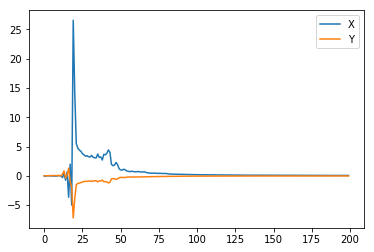

In [7]:
draw(s.x, [0, 1], ['X', 'Y'])

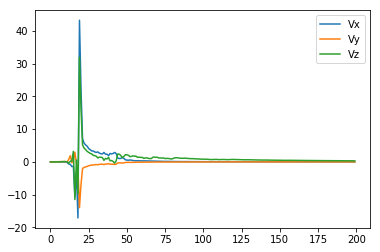

In [8]:
draw(s.x, [2, 3, 4], ['Vx', 'Vy', 'Vz'])

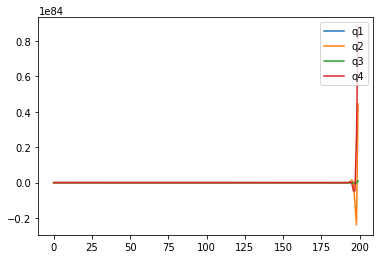

In [9]:
draw(s.x, [5, 6, 7, 8], ['q1', 'q2', 'q3', 'q4'])

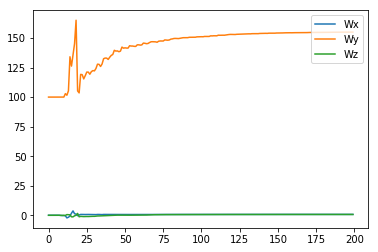

In [10]:
draw(s.x, [9, 10, 11], ['Wx', 'Wy', 'Wz'])

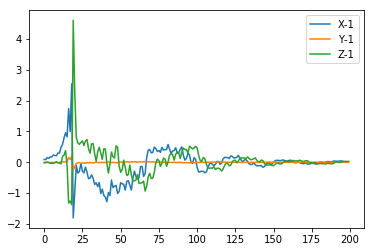

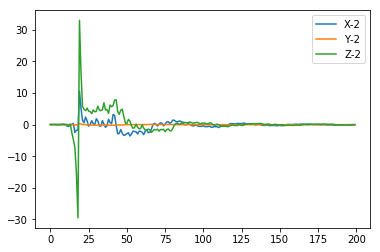

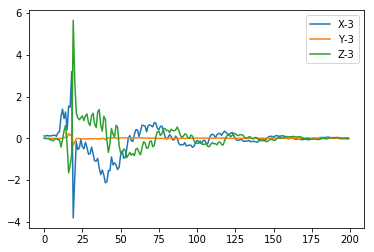

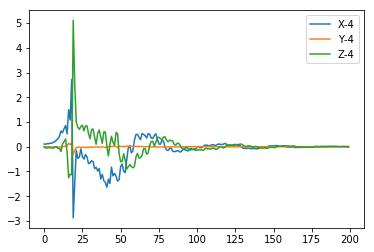

In [11]:
for i in range(M):
    draw(s.x, [12+i*3, 13+i*3, 14+i*3], ['X-'+str(i+1), 'Y-'+str(i+1), 'Z-'+str(i+1)])

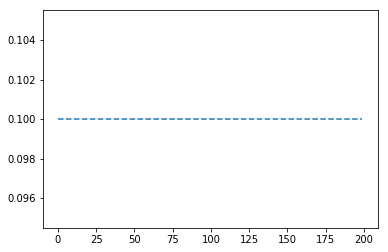

In [173]:
plt.plot([0.1]*200, linestyle='--');
plt.show()